# Animal Image Classification with CNN

In this notebook, a classification model is trained using Convolutional Neural Networks on an animal dataset with ten different classes to predict what animal class an image belongs to.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Preprocessing Data](#2)
  - [ 2.1 Loading and Visualizing the Data](#2.1)
  - [ 2.2 Convert to arrays](#2.2)
  - [ 2.3 Tensor Training Set](#2.3)
  - [ 2.4 Normalize](#2.4)
- [ 3 - CNN Classification Model](#3)
  - [ 3.1 Training](#3.1)
  - [ 3.2 Testing](#3.2)
- [ 4 - Results](#4)

<a name="1"></a>
## 1 - Packages 

Below are all the needed packages for this notebook.
- [numpy](https://www.numpy.org) is the fundamental package for scientific computing with Python.
- [os](https://docs.python.org/3/library/os.html) is the python module that provides a portable way of using operating system dependent functionality.
- [cv2](https://opencv.org) is a computer vision library.
- [tensorflow](https://www.tensorflow.org) is an end-to-end machine learning platform.
- [matplotlib](https://matplotlib.org) is a comprehensive library for creating static, animated, and interactive visualizations in Python.

In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import TensorBoard

%matplotlib widget
import matplotlib.pyplot as plt

<a name="2"></a>
## 2 - Preprocessing Data

The dataset for the model we'll build contains 10 animal classes for 28k medium quality images. There is also some erroneous data in the dataset.

The dataset can be found here: [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10?select=raw-img&utm_source=pocket_saves)
<br/><br/>
<a name="2.1"></a>
### 2.1 Loading and Visualizing the Data

In [2]:
#Load data
data_path = "./Data/train"
categories = ["Butterfly", "Cat", "Chicken", "Cow", "Dog", "Elephant", "Horse", "Sheep", "Spider", "Squirrel"]

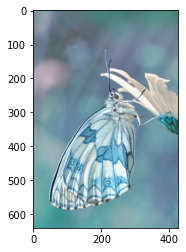

In [3]:
#Display first image of first class
for category in categories:
    path = os.path.join(data_path, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.show()
        plt.close()
        break
    break

We'll have to resize the images to a smaller scale in order to train a model. Let's preview the image above in 80x80 pixels.

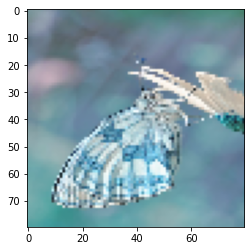

In [4]:
#Resize image
img_sized = cv2.resize(img_array, (80, 80))
plt.imshow(img_sized)
plt.show()
plt.close()

The image is now more pixelated, but the butterfly pattern can still be clearly seen.
<br/><br/>
<a name="2.2"></a>
### 2.2 Convert to arrays

Now, we can resize all the images and turn them into arrays, along with its class number.

In [5]:
data = []

#List of image arrays with their respective class
def create_training_data():
    for category in categories:
        path = os.path.join(data_path, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_resized = cv2.resize(img_array, (80, 80))
                data.append([img_resized, class_num])
            except Exception as e:
                pass
                

create_training_data()

In [6]:
DATASET_SIZE = len(data)
print(f"# of images: {DATASET_SIZE}")

# of images: 26179


In [7]:
print(f"First image [img array, class]:\n\n{data[0]}")

First image [img array, class]:

[array([[[120, 149, 153],
        [124, 150, 156],
        [128, 152, 158],
        ...,
        [ 73, 133, 117],
        [ 73, 132, 112],
        [ 71, 129, 109]],

       [[117, 146, 150],
        [122, 148, 154],
        [127, 151, 157],
        ...,
        [ 76, 132, 119],
        [ 74, 129, 111],
        [ 73, 125, 108]],

       [[119, 144, 148],
        [122, 147, 151],
        [128, 151, 157],
        ...,
        [ 80, 133, 121],
        [ 81, 130, 117],
        [ 80, 127, 115]],

       ...,

       [[ 96, 165, 165],
        [ 92, 164, 164],
        [ 91, 164, 164],
        ...,
        [101, 144, 161],
        [102, 145, 162],
        [101, 145, 162]],

       [[ 87, 162, 162],
        [ 85, 162, 161],
        [ 86, 163, 162],
        ...,
        [101, 144, 162],
        [ 98, 142, 159],
        [ 96, 143, 157]],

       [[ 81, 161, 162],
        [ 80, 161, 162],
        [ 79, 161, 162],
        ...,
        [ 99, 143, 160],
        [ 98, 1

Before we get our x and y variables, lets shuffle our data.

In [8]:
import random
random.shuffle(data)

#Class in data
print("First 5 classes:", end=" ")
for sample in data[:5]:
    print(sample[1], end=" ")

First 5 classes: 1 1 7 4 8 

<a name="2.3"></a>
### 2.3 Tensor Training Set

The X variable will have the image arrays and Y will contain the class labels. We will first convert them into a numpy array and then to a tensor for our tensorflow model.

In [9]:
X = []
Y = []

#Get features and labels
for features, label in data:
        X.append(features)
        Y.append(label)
    
X = np.array(X).reshape(-1, 80, 80, 3)
Y = np.array(Y)

X = tf.convert_to_tensor(X,dtype=tf.float32)
Y = tf.convert_to_tensor(Y,dtype=tf.float32)

In [10]:
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (26179, 80, 80, 3)
Y shape: (26179,)


<a name="2.4"></a>
### 2.4 Normalize

We can also normalize our data by dividing the array values by the max pixel number 255.

In [11]:
#Normalize
X = X/255.0

<a name="3"></a>
## 3 - CNN Classification Model

We will use a Sequential model to construct our CNN model. It will consist of an input convolutional layer with 256 neurons and a pooling layer. 3 more convolutional layers with 512 neurons and a pooling layer follow, with a flattening layer next, and a dropout layer to reduce overfitting. The output layer is a Dense layer with the 10 class neurons. A linear activation with a SparseCategoricalCrossEntropy loss function is used, as it is better computiationally than a softmax activation.

In [12]:
model = Sequential(
    [   
        Conv2D(256, (3,3), activation="relu", input_shape=X.shape[1:]),
        MaxPooling2D(pool_size=(2,2)),                   
        
        Conv2D(512, (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(512, (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(512, (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        
        Flatten(),                  
        
        Dropout(0.7),
        
        Dense(10, activation='linear')
    ], name = "my_model" 
)

In [13]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 512)       1180160   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 512)       2359808   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 512)        0  

<a name="3.1"></a>
### 3.1 Training

A split of 30% is applied to the data to use as validation set.

In [14]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    metrics=['accuracy']
)

history = model.fit(
    X,Y,
    batch_size = 128,
    validation_split = 0.3,
    epochs = 24,
)

Epoch 1/24
144/144 [==============================] - 34s 170ms/step - loss: 2.0666 - accuracy: 0.2690 - val_loss: 1.8771 - val_accuracy: 0.3453
Epoch 2/24
144/144 [==============================] - 23s 157ms/step - loss: 1.7113 - accuracy: 0.4094 - val_loss: 1.5069 - val_accuracy: 0.4785
Epoch 3/24
144/144 [==============================] - 23s 157ms/step - loss: 1.4705 - accuracy: 0.4961 - val_loss: 1.3515 - val_accuracy: 0.5518
Epoch 4/24
144/144 [==============================] - 23s 157ms/step - loss: 1.3134 - accuracy: 0.5560 - val_loss: 1.2394 - val_accuracy: 0.5755
Epoch 5/24
144/144 [==============================] - 23s 157ms/step - loss: 1.2070 - accuracy: 0.5891 - val_loss: 1.1452 - val_accuracy: 0.6143
Epoch 6/24
144/144 [==============================] - 23s 159ms/step - loss: 1.1089 - accuracy: 0.6211 - val_loss: 1.0730 - val_accuracy: 0.6385
Epoch 7/24
144/144 [==============================] - 23s 158ms/step - loss: 1.0517 - accuracy: 0.6410 - val_loss: 0.9825 - val_ac

<a name="3.2"></a>
### 3.2 Testing

We'll do a sample test with a picture of my dog, so this a unique image. We preprocess the image and predict to which class it belongs using our model.

In [15]:
sample_path = "./Data/test/dog.JPG"
img_array = cv2.imread(sample_path)

#Preprocess image
img_resized = cv2.resize(img_array, (80, 80))
test_img = np.array(img_resized).reshape(-1, 80, 80, 3)
test_img = tf.convert_to_tensor(test_img,dtype=tf.float32)
test_img = test_img/255.0

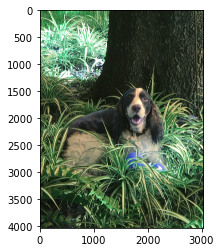

In [16]:
fig, ax = plt.subplots()
ax.imshow(img_array)

In [27]:
#Predict image class using model
prediction = model.predict(tf.reshape(test_img, [-1, 80, 80, 3]))  # image prediction
yhat = np.argmax(prediction)

print(f"\nClass Predictions: {prediction}")
print(f"\nLargest Prediction index: {yhat}")
print(f"\nClass: {categories[int(yhat)]}")

1/1 [==============================] - 0s 12ms/step

Class Predictions: [[-4.544973  -3.3534412  0.8342287 -2.8558464  1.2517095 -4.132342
  -3.0627396 -3.5894308 -2.729835  -2.5514443]]

Largest Prediction index: 4

Class: Dog


Our model correctly predicts the test image.

<a name="4"></a>
## 4 - Results


loss: 0.3701736330986023
accuracy: 0.8704501986503601
val_loss: 0.7513570785522461
val_accuracy: 0.7697988152503967


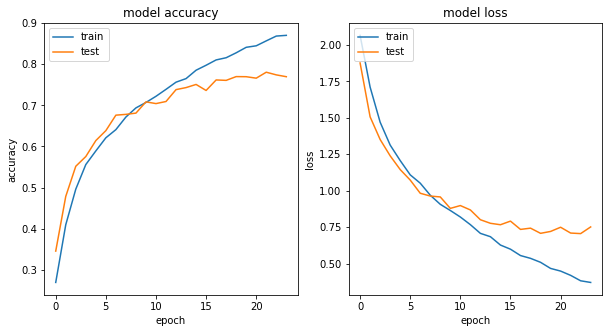

In [19]:
#Plot accuracy and loss history
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper left')

print(f"\nloss: {history.history['loss'][-1]}")
print(f"accuracy: {history.history['accuracy'][-1]}")
print(f"val_loss: {history.history['val_loss'][-1]}")
print(f"val_accuracy: {history.history['val_accuracy'][-1]}")

From the graphs, we can see that our validation accurracy and loss function start to converge in the end. Further epochs would result in overfitting for our training set. With an accuracy of 0.75 and loss function with a value of 0.77 for the validation set, and an accuracy of 0.87 and a loss function of 0.37 for our training set, we have a good model. A bigger image size would enable us to add more convolutional layers and further improve our results.